In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split
import os

In [2]:
cwd = os.getcwd()
os.chdir("C:\\Users\\MPC\\Downloads")
cwd
dataset = pd.read_excel('Davidova28nT(12.19-05.20).xls')

dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Код ошибки,4041.0,254813.568919,685251.072218,0.0,0.0,0.0,0.0,2097152.0


In [3]:
dataset.drop([0,1], inplace=True)
dataset.rename(columns={'Время': 'Time', 'Tвн': 'T_home', 'Tнв':'T_Outside'}, inplace=True)
dataset = dataset.query("~(Q <= 0)")
dataset = dataset.fillna(method='ffill')
dataset = dataset.drop(['ЧН', 'Код ошибки'], axis=1)
dataset.head()

,T_home,Q,M1,M2,dM,T1,T2,dT,T_Outside,deltaM,P1,P2,dP
2,21.940816,0.064528,2.233756,1.875612,0.358144,59.732147,35.838188,23.893959,-1.982143,17.430612,7.658507,3.989966,3.668541
3,21.997973,0.050693,2.038099,1.956182,0.081917,59.315968,35.734474,23.581494,-1.986250,4.101714,7.666063,4.004507,3.661556
4,21.999592,0.052936,2.045773,1.905203,0.140570,59.377853,35.663296,23.714557,-2.010000,7.115710,7.691383,4.011880,3.679503
5,22.000000,0.045167,1.931992,1.954105,-0.022113,59.281757,35.612133,23.669624,-1.954643,-1.138057,7.740299,4.014082,3.726216
6,22.009262,0.048108,1.981013,1.944919,0.036094,59.337376,35.668209,23.669167,-1.852143,1.838748,7.747794,4.024565,3.723229


In [4]:
dataset.corr()[['Q']].sort_values('Q').T

,T_Outside,dP,P1,deltaM,T2,T_home,dM,dT,T1,P2,M2,M1,Q
Q,-0.834254,-0.661147,-0.367741,-0.322663,0.134361,0.254302,0.317688,0.405573,0.743272,0.779505,0.850582,0.892324,1.0


In [5]:
# X = dataset[[col for col in dataset.columns if col != 'Q']]
X = dataset[['T_home','T_Outside','M1', 'M2', 'P2', 'T1']]

y = dataset['Q']

In [6]:
# разделить данные на обучающий набор и временный набор с помощью sklearn.model_selection.traing_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)

In [7]:
# беру оставшиеся 20% данных в X_tmp, y_tmp и разделю их поровну
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

X_train.shape, X_test.shape, X_val.shape
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))

Training instances   3232, Training features   6
Validation instances 405, Validation features 6
Testing instances    404, Testing features    6


In [8]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

In [9]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [29]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50])
evaluations = []
STEPS = 400
for i in range(300):
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\MPC\\AppData\\Local\\Temp\\tmp6of3cm09', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018E19E1FA58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkpoi

INFO:tensorflow:loss = 0.9089457, step = 1901 (0.697 sec)
INFO:tensorflow:Saving checkpoints for 2000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.9339926.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:22:27Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:22:27
INFO:tensorflow:Saving dict for global step 2000: average_loss = 0.00224057, global_step = 2000, label/mean = 0.07104105, loss = 0.45371544, prediction/mean = 0.06887002
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-2000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

INFO:tensorflow:global_step/sec: 141.213
INFO:tensorflow:loss = 0.3033892, step = 3901 (0.713 sec)
INFO:tensorflow:Saving checkpoints for 4000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.29688847.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:22:59Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-4000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:22:59
INFO:tensorflow:Saving dict for global step 4000: average_loss = 0.00066293083, global_step = 4000, label/mean = 0.07104105, loss = 0.13424349, prediction/mean = 0.07092316
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4000: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-4000
INFO:tensorflow:Calling model

INFO:tensorflow:global_step/sec: 148.205
INFO:tensorflow:loss = 0.16880848, step = 5801 (0.678 sec)
INFO:tensorflow:global_step/sec: 144.372
INFO:tensorflow:loss = 0.17731178, step = 5901 (0.693 sec)
INFO:tensorflow:Saving checkpoints for 6000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.1811477.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:23:31Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:23:32
INFO:tensorflow:Saving dict for global step 6000: average_loss = 0.00038564779, global_step = 6000, label/mean = 0.07104105, loss = 0.07809368, prediction/mean = 0.07208716
INFO:tensorflow:Saving 'checkpoint_path' summary for global 

INFO:tensorflow:global_step/sec: 86.0662
INFO:tensorflow:loss = 0.12781847, step = 7701 (1.168 sec)
INFO:tensorflow:global_step/sec: 104.47
INFO:tensorflow:loss = 0.14001226, step = 7801 (0.958 sec)
INFO:tensorflow:global_step/sec: 103.468
INFO:tensorflow:loss = 0.12455775, step = 7901 (0.961 sec)
INFO:tensorflow:Saving checkpoints for 8000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.12101896.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:24:11Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:24:11
INFO:tensorflow:Saving dict for global step 8000: average_loss = 0.00029596785, global_step = 8000, label/mean = 0.07104105, loss = 0

INFO:tensorflow:loss = 0.100685626, step = 9601
INFO:tensorflow:global_step/sec: 79.0402
INFO:tensorflow:loss = 0.11442382, step = 9701 (1.273 sec)
INFO:tensorflow:global_step/sec: 93.5425
INFO:tensorflow:loss = 0.10831954, step = 9801 (1.071 sec)
INFO:tensorflow:global_step/sec: 93.2803
INFO:tensorflow:loss = 0.11166466, step = 9901 (1.071 sec)
INFO:tensorflow:Saving checkpoints for 10000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.118759215.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:24:53Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:24:54
INFO:tensorflow:Saving dict for global step 10000: average_loss = 0.00026277505, 

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 11600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.10119471, step = 11601
INFO:tensorflow:global_step/sec: 77.0985
INFO:tensorflow:loss = 0.08426002, step = 11701 (1.306 sec)
INFO:tensorflow:global_step/sec: 90.8216
INFO:tensorflow:loss = 0.11134662, step = 11801 (1.099 sec)
INFO:tensorflow:global_step/sec: 88.458
INFO:tensorflow:loss = 0.09419497, step = 11901 (1.132 sec)
INFO:tensorflow:Saving checkpoints for 12000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.0863768.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:25:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-13600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 13600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.10051348, step = 13601
INFO:tensorflow:global_step/sec: 71.0697
INFO:tensorflow:loss = 0.09415162, step = 13701 (1.411 sec)
INFO:tensorflow:global_step/sec: 83.2759
INFO:tensorflow:loss = 0.10099401, step = 13801 (1.203 sec)
INFO:tensorflow:global_step/sec: 83.3946
INFO:tensorflow:loss = 0.093259946, step = 13901 (1.199 sec)
INFO:tensorflow:Saving checkpoints for 14000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.09845662.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:26:37Z
INFO:tensorflow:Graph was final

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-15600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 15600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.095746085, step = 15601
INFO:tensorflow:global_step/sec: 70.5586
INFO:tensorflow:loss = 0.085697174, step = 15701 (1.420 sec)
INFO:tensorflow:global_step/sec: 82.451
INFO:tensorflow:loss = 0.099911526, step = 15801 (1.218 sec)
INFO:tensorflow:global_step/sec: 88.5787
INFO:tensorflow:loss = 0.085835576, step = 15901 (1.124 sec)
INFO:tensorflow:Saving checkpoints for 16000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.0929827.
INFO:tensorflow:Calling model_fn.
INFO:tensorf

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 17600: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-17600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-17600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 17600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.090144716, step = 17601
INFO:tensorflow:global_step/sec: 68.6053
INFO:tensorflow:loss = 0.08690833, step = 17701 (1.468 sec)
INFO:tensorflow:global_step/sec: 75.7308
INFO:tensorflow:loss = 0.09217253, step = 17801 (1.319 sec)
INFO:tensorflow:global_step/sec: 67.7693
INFO:tensorflow:loss = 0.085015394, step = 17901 (1.469 sec)
INFO:tensorflow:Saving checkpoints for 18000 into C:\Users\MPC\AppDa

INFO:tensorflow:Saving dict for global step 19600: average_loss = 0.00019837811, global_step = 19600, label/mean = 0.07104105, loss = 0.040171567, prediction/mean = 0.07386627
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 19600: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-19600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-19600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 19600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.077022605, step = 19601
INFO:tensorflow:global_step/sec: 73.4236
INFO:tensorflow:loss = 0.078019366, step = 19701 (1.365 sec)
INFO:tensorflow:global_step/sec: 92.322
INFO:tensorflow:loss = 0.09397122, step = 19801 (1.088

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:30:27
INFO:tensorflow:Saving dict for global step 21600: average_loss = 0.00018611866, global_step = 21600, label/mean = 0.07104105, loss = 0.03768903, prediction/mean = 0.072905704
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 21600: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-21600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-21600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 21600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.07786613, step = 21601
INFO:tensorflow:global_step/sec: 69.5341
INFO:tensorflo

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-23600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:31:32
INFO:tensorflow:Saving dict for global step 23600: average_loss = 0.00018701467, global_step = 23600, label/mean = 0.07104105, loss = 0.03787047, prediction/mean = 0.074506186
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 23600: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-23600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-23600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 23600 into C:\Users\MPC\AppDat

INFO:tensorflow:Loss for final step: 0.07772787.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:32:37Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-25600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:32:38
INFO:tensorflow:Saving dict for global step 25600: average_loss = 0.00017298426, global_step = 25600, label/mean = 0.07104105, loss = 0.035029314, prediction/mean = 0.073186114
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 25600: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-25600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Tem

INFO:tensorflow:loss = 0.069166005, step = 27501 (1.257 sec)
INFO:tensorflow:Saving checkpoints for 27600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.067291014.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:33:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-27600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:33:41
INFO:tensorflow:Saving dict for global step 27600: average_loss = 0.0001621206, global_step = 27600, label/mean = 0.07104105, loss = 0.032829423, prediction/mean = 0.0713712
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 27600: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-27600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done callin

INFO:tensorflow:global_step/sec: 75.7427
INFO:tensorflow:loss = 0.0651215, step = 29401 (1.321 sec)
INFO:tensorflow:global_step/sec: 84.8877
INFO:tensorflow:loss = 0.069431625, step = 29501 (1.184 sec)
INFO:tensorflow:Saving checkpoints for 29600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.060316466.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:34:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-29600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:34:45
INFO:tensorflow:Saving dict for global step 29600: average_loss = 0.00015686029, global_step = 29600, label/mean = 0.07104105, loss = 0.03176421, prediction/mean = 0.07184381
INFO:tensorflow:Saving 'checkpoint_path' summary for

INFO:tensorflow:loss = 0.07297574, step = 31201
INFO:tensorflow:global_step/sec: 59.6021
INFO:tensorflow:loss = 0.06493597, step = 31301 (1.683 sec)
INFO:tensorflow:global_step/sec: 86.8288
INFO:tensorflow:loss = 0.069327235, step = 31401 (1.149 sec)
INFO:tensorflow:global_step/sec: 88.1432
INFO:tensorflow:loss = 0.059568934, step = 31501 (1.135 sec)
INFO:tensorflow:Saving checkpoints for 31600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.06806096.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:35:49Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-31600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:35:50
INFO:tensorflow:Saving dict for global step 31600: average_loss = 0.000157138

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 33200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.06390492, step = 33201
INFO:tensorflow:global_step/sec: 69.8239
INFO:tensorflow:loss = 0.06644149, step = 33301 (1.438 sec)
INFO:tensorflow:global_step/sec: 87.8605
INFO:tensorflow:loss = 0.06357254, step = 33401 (1.137 sec)
INFO:tensorflow:global_step/sec: 90.0314
INFO:tensorflow:loss = 0.06737387, step = 33501 (1.108 sec)
INFO:tensorflow:Saving checkpoints for 33600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.06566414.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:36:55Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-33600
INFO:tensorflow:Running local_in

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-35200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 35200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.06097658, step = 35201
INFO:tensorflow:global_step/sec: 71.2354
INFO:tensorflow:loss = 0.052637618, step = 35301 (1.414 sec)
INFO:tensorflow:global_step/sec: 84.5704
INFO:tensorflow:loss = 0.063731946, step = 35401 (1.177 sec)
INFO:tensorflow:global_step/sec: 80.389
INFO:tensorflow:loss = 0.055800483, step = 35501 (1.248 sec)
INFO:tensorflow:Saving checkpoints for 35600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.06104766.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-37200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 37200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.057487406, step = 37201
INFO:tensorflow:global_step/sec: 70.3282
INFO:tensorflow:loss = 0.062768385, step = 37301 (1.429 sec)
INFO:tensorflow:global_step/sec: 85.4625
INFO:tensorflow:loss = 0.05393465, step = 37401 (1.169 sec)
INFO:tensorflow:global_step/sec: 81.9268
INFO:tensorflow:loss = 0.06718649, step = 37501 (1.221 sec)
INFO:tensorflow:Saving checkpoints for 37600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.05875243.
INFO:tensorflow:Calling model_fn.
INFO:tensorf

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 39200: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-39200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-39200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 39200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.06307991, step = 39201
INFO:tensorflow:global_step/sec: 70.3923
INFO:tensorflow:loss = 0.051636674, step = 39301 (1.441 sec)
INFO:tensorflow:global_step/sec: 82.3867
INFO:tensorflow:loss = 0.05167334, step = 39401 (1.200 sec)
INFO:tensorflow:global_step/sec: 87.0591
INFO:tensorflow:loss = 0.05546668, step = 39501 (1.148 sec)
INFO:tensorflow:Saving checkpoints for 39600 into C:\Users\MPC\AppDat

INFO:tensorflow:Saving dict for global step 41200: average_loss = 0.00013028734, global_step = 41200, label/mean = 0.07104105, loss = 0.026383188, prediction/mean = 0.072748445
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 41200: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-41200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-41200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 41200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.04966853, step = 41201
INFO:tensorflow:global_step/sec: 65.9258
INFO:tensorflow:loss = 0.053196527, step = 41301 (1.521 sec)
INFO:tensorflow:global_step/sec: 84.2247
INFO:tensorflow:loss = 0.05519677, step = 41401 (1.18

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:42:14
INFO:tensorflow:Saving dict for global step 43200: average_loss = 0.00012550666, global_step = 43200, label/mean = 0.07104105, loss = 0.025415098, prediction/mean = 0.07246976
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 43200: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-43200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-43200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 43200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.055442855, step = 43201
INFO:tensorflow:global_step/sec: 69.0066
INFO:tensorfl

INFO:tensorflow:Starting evaluation at 2021-06-15T13:43:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-45200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:43:20
INFO:tensorflow:Saving dict for global step 45200: average_loss = 0.00012037351, global_step = 45200, label/mean = 0.07104105, loss = 0.024375636, prediction/mean = 0.07180116
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 45200: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-45200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-45200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tens

INFO:tensorflow:Loss for final step: 0.044820987.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:44:25Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-47200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:44:26
INFO:tensorflow:Saving dict for global step 47200: average_loss = 0.00011679103, global_step = 47200, label/mean = 0.07104105, loss = 0.023650184, prediction/mean = 0.07176833
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 47200: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-47200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Tem

INFO:tensorflow:loss = 0.05201687, step = 49101 (1.133 sec)
INFO:tensorflow:Saving checkpoints for 49200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.04830207.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:45:31Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-49200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:45:31
INFO:tensorflow:Saving dict for global step 49200: average_loss = 0.000114632254, global_step = 49200, label/mean = 0.07104105, loss = 0.02321303, prediction/mean = 0.07237137
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 49200: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-49200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done callin

INFO:tensorflow:global_step/sec: 84.2494
INFO:tensorflow:loss = 0.042047366, step = 51001 (1.188 sec)
INFO:tensorflow:global_step/sec: 85.943
INFO:tensorflow:loss = 0.042233966, step = 51101 (1.163 sec)
INFO:tensorflow:Saving checkpoints for 51200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.04430265.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:46:35Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-51200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:46:36
INFO:tensorflow:Saving dict for global step 51200: average_loss = 0.00011136067, global_step = 51200, label/mean = 0.07104105, loss = 0.022550536, prediction/mean = 0.07232292
INFO:tensorflow:Saving 'checkpoint_path' summary fo

INFO:tensorflow:loss = 0.051719725, step = 52801
INFO:tensorflow:global_step/sec: 69.1574
INFO:tensorflow:loss = 0.03928107, step = 52901 (1.449 sec)
INFO:tensorflow:global_step/sec: 85.5309
INFO:tensorflow:loss = 0.04341869, step = 53001 (1.172 sec)
INFO:tensorflow:global_step/sec: 87.5002
INFO:tensorflow:loss = 0.04583609, step = 53101 (1.142 sec)
INFO:tensorflow:Saving checkpoints for 53200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.047748804.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:47:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-53200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:47:41
INFO:tensorflow:Saving dict for global step 53200: average_loss = 0.000110331

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 54800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.046713643, step = 54801
INFO:tensorflow:global_step/sec: 71.2633
INFO:tensorflow:loss = 0.046843898, step = 54901 (1.409 sec)
INFO:tensorflow:global_step/sec: 89.0012
INFO:tensorflow:loss = 0.041117698, step = 55001 (1.125 sec)
INFO:tensorflow:global_step/sec: 87.4142
INFO:tensorflow:loss = 0.040955365, step = 55101 (1.143 sec)
INFO:tensorflow:Saving checkpoints for 55200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.042918526.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:48:47Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-55200
INFO:tensorflow:Running loc

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-56800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 56800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.04411431, step = 56801
INFO:tensorflow:global_step/sec: 70.8833
INFO:tensorflow:loss = 0.044141777, step = 56901 (1.415 sec)
INFO:tensorflow:global_step/sec: 89.7614
INFO:tensorflow:loss = 0.045021996, step = 57001 (1.116 sec)
INFO:tensorflow:global_step/sec: 87.8527
INFO:tensorflow:loss = 0.044837274, step = 57101 (1.138 sec)
INFO:tensorflow:Saving checkpoints for 57200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.0417057.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-58800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 58800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.04147483, step = 58801
INFO:tensorflow:global_step/sec: 70.9315
INFO:tensorflow:loss = 0.038503777, step = 58901 (1.417 sec)
INFO:tensorflow:global_step/sec: 81.7975
INFO:tensorflow:loss = 0.041474506, step = 59001 (1.223 sec)
INFO:tensorflow:global_step/sec: 84.5983
INFO:tensorflow:loss = 0.0430019, step = 59101 (1.185 sec)
INFO:tensorflow:Saving checkpoints for 59200 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.04602045.
INFO:tensorflow:Calling model_fn.
INFO:tensorfl

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60800: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-60800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-60800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 60800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.04072831, step = 60801
INFO:tensorflow:global_step/sec: 70.2647
INFO:tensorflow:loss = 0.03850417, step = 60901 (1.432 sec)
INFO:tensorflow:global_step/sec: 85.8378
INFO:tensorflow:loss = 0.038981333, step = 61001 (1.165 sec)
INFO:tensorflow:global_step/sec: 86.4733
INFO:tensorflow:loss = 0.03977866, step = 61101 (1.154 sec)
INFO:tensorflow:Saving checkpoints for 61200 into C:\Users\MPC\AppDat

INFO:tensorflow:Saving dict for global step 62800: average_loss = 9.7823395e-05, global_step = 62800, label/mean = 0.07104105, loss = 0.019809237, prediction/mean = 0.072891586
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 62800: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-62800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-62800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 62800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.042542778, step = 62801
INFO:tensorflow:global_step/sec: 72.2392
INFO:tensorflow:loss = 0.041543424, step = 62901 (1.392 sec)
INFO:tensorflow:global_step/sec: 85.8323
INFO:tensorflow:loss = 0.04315164, step = 63001 (1.1

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:53:57
INFO:tensorflow:Saving dict for global step 64800: average_loss = 9.401678e-05, global_step = 64800, label/mean = 0.07104105, loss = 0.019038398, prediction/mean = 0.07245012
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 64800: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-64800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-64800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 64800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.043006625, step = 64801
INFO:tensorflow:global_step/sec: 70.307
INFO:tensorflow

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-66800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:55:03
INFO:tensorflow:Saving dict for global step 66800: average_loss = 9.195492e-05, global_step = 66800, label/mean = 0.07104105, loss = 0.018620871, prediction/mean = 0.07250186
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 66800: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-66800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-66800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 66800 into C:\Users\MPC\AppData

INFO:tensorflow:Loss for final step: 0.033994026.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:56:09Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-68800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:56:11
INFO:tensorflow:Saving dict for global step 68800: average_loss = 8.933398e-05, global_step = 68800, label/mean = 0.07104105, loss = 0.01809013, prediction/mean = 0.07226744
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 68800: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-68800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\

INFO:tensorflow:loss = 0.03444062, step = 70701 (1.208 sec)
INFO:tensorflow:Saving checkpoints for 70800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.03383732.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:57:17Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-70800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:57:18
INFO:tensorflow:Saving dict for global step 70800: average_loss = 8.71925e-05, global_step = 70800, label/mean = 0.07104105, loss = 0.01765648, prediction/mean = 0.072216436
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 70800: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-70800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling 

INFO:tensorflow:global_step/sec: 85.6835
INFO:tensorflow:loss = 0.033408806, step = 72601 (1.166 sec)
INFO:tensorflow:global_step/sec: 83.9013
INFO:tensorflow:loss = 0.033736438, step = 72701 (1.189 sec)
INFO:tensorflow:Saving checkpoints for 72800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.035233922.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:58:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-72800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:58:25
INFO:tensorflow:Saving dict for global step 72800: average_loss = 8.774278e-05, global_step = 72800, label/mean = 0.07104105, loss = 0.017767914, prediction/mean = 0.07300523
INFO:tensorflow:Saving 'checkpoint_path' summary f

INFO:tensorflow:loss = 0.031804867, step = 74401
INFO:tensorflow:global_step/sec: 73.0567
INFO:tensorflow:loss = 0.036527827, step = 74501 (1.376 sec)
INFO:tensorflow:global_step/sec: 87.5715
INFO:tensorflow:loss = 0.037394203, step = 74601 (1.143 sec)
INFO:tensorflow:global_step/sec: 85.7159
INFO:tensorflow:loss = 0.033728875, step = 74701 (1.166 sec)
INFO:tensorflow:Saving checkpoints for 74800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.031576492.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T13:59:35Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-74800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-13:59:36
INFO:tensorflow:Saving dict for global step 74800: average_loss = 8.641327

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 76400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.02946468, step = 76401
INFO:tensorflow:global_step/sec: 68.2333
INFO:tensorflow:loss = 0.03590632, step = 76501 (1.473 sec)
INFO:tensorflow:global_step/sec: 81.0788
INFO:tensorflow:loss = 0.03402218, step = 76601 (1.232 sec)
INFO:tensorflow:global_step/sec: 83.533
INFO:tensorflow:loss = 0.03684768, step = 76701 (1.197 sec)
INFO:tensorflow:Saving checkpoints for 76800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.036124278.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:00:42Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-76800
INFO:tensorflow:Running local_in

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-78400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 78400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.032551914, step = 78401
INFO:tensorflow:global_step/sec: 69.0176
INFO:tensorflow:loss = 0.03325115, step = 78501 (1.453 sec)
INFO:tensorflow:global_step/sec: 80.0559
INFO:tensorflow:loss = 0.028310288, step = 78601 (1.250 sec)
INFO:tensorflow:global_step/sec: 80.721
INFO:tensorflow:loss = 0.02514457, step = 78701 (1.242 sec)
INFO:tensorflow:Saving checkpoints for 78800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.035609268.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-80400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 80400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.02610533, step = 80401
INFO:tensorflow:global_step/sec: 66.1145
INFO:tensorflow:loss = 0.026835594, step = 80501 (1.518 sec)
INFO:tensorflow:global_step/sec: 81.7941
INFO:tensorflow:loss = 0.03408461, step = 80601 (1.219 sec)
INFO:tensorflow:global_step/sec: 82.6419
INFO:tensorflow:loss = 0.03211278, step = 80701 (1.216 sec)
INFO:tensorflow:Saving checkpoints for 80800 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.03239594.
INFO:tensorflow:Calling model_fn.
INFO:tensorfl

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 82400: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-82400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-82400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 82400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.03466314, step = 82401
INFO:tensorflow:global_step/sec: 75.1387
INFO:tensorflow:loss = 0.031921506, step = 82501 (1.336 sec)
INFO:tensorflow:global_step/sec: 92.3062
INFO:tensorflow:loss = 0.02870544, step = 82601 (1.083 sec)
INFO:tensorflow:global_step/sec: 92.7432
INFO:tensorflow:loss = 0.029884119, step = 82701 (1.077 sec)
INFO:tensorflow:Saving checkpoints for 82800 into C:\Users\MPC\AppDa

INFO:tensorflow:Saving dict for global step 84400: average_loss = 7.627616e-05, global_step = 84400, label/mean = 0.07104105, loss = 0.015445923, prediction/mean = 0.072316535
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 84400: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-84400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-84400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 84400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.023461495, step = 84401
INFO:tensorflow:global_step/sec: 71.3609
INFO:tensorflow:loss = 0.029006802, step = 84501 (1.407 sec)
INFO:tensorflow:global_step/sec: 80.1556
INFO:tensorflow:loss = 0.032729, step = 84601 (1.247 

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:05:58
INFO:tensorflow:Saving dict for global step 86400: average_loss = 7.6786055e-05, global_step = 86400, label/mean = 0.07104105, loss = 0.015549176, prediction/mean = 0.07291012
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 86400: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-86400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-86400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 86400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.032488775, step = 86401
INFO:tensorflow:global_step/sec: 72.547
INFO:tensorflo

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-88400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:07:02
INFO:tensorflow:Saving dict for global step 88400: average_loss = 7.388982e-05, global_step = 88400, label/mean = 0.07104105, loss = 0.01496269, prediction/mean = 0.07239092
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 88400: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-88400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-88400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 88400 into C:\Users\MPC\AppData\

INFO:tensorflow:Loss for final step: 0.025275365.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:07:59Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-90400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:08:00
INFO:tensorflow:Saving dict for global step 90400: average_loss = 7.558364e-05, global_step = 90400, label/mean = 0.07104105, loss = 0.015305687, prediction/mean = 0.07321353
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 90400: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-90400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp

INFO:tensorflow:global_step/sec: 124.711
INFO:tensorflow:loss = 0.028013071, step = 92301 (0.802 sec)
INFO:tensorflow:Saving checkpoints for 92400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.024635002.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:08:39Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-92400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:08:39
INFO:tensorflow:Saving dict for global step 92400: average_loss = 7.054517e-05, global_step = 92400, label/mean = 0.07104105, loss = 0.014285396, prediction/mean = 0.071948394
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 92400: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-92400
INFO:tensorflow:Ca

INFO:tensorflow:loss = 0.02679805, step = 94101 (0.871 sec)
INFO:tensorflow:global_step/sec: 135.68
INFO:tensorflow:loss = 0.027548805, step = 94201 (0.738 sec)
INFO:tensorflow:global_step/sec: 132.805
INFO:tensorflow:loss = 0.02339292, step = 94301 (0.753 sec)
INFO:tensorflow:Saving checkpoints for 94400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.024906512.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:09:12Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-94400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:09:12
INFO:tensorflow:Saving dict for global step 94400: average_loss = 6.963622e-05, global_step = 94400, label/mean = 0.07104105, loss = 0.014101334, prediction/mean = 0.0

INFO:tensorflow:loss = 0.027435135, step = 96001
INFO:tensorflow:global_step/sec: 115.383
INFO:tensorflow:loss = 0.025229257, step = 96101 (0.873 sec)
INFO:tensorflow:global_step/sec: 138.683
INFO:tensorflow:loss = 0.025635427, step = 96201 (0.719 sec)
INFO:tensorflow:global_step/sec: 136.045
INFO:tensorflow:loss = 0.02735845, step = 96301 (0.738 sec)
INFO:tensorflow:Saving checkpoints for 96400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.025572924.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:09:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-96400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:09:45
INFO:tensorflow:Saving dict for global step 96400: average_loss = 6.8672925

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 98000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.028101204, step = 98001
INFO:tensorflow:global_step/sec: 116.32
INFO:tensorflow:loss = 0.025642984, step = 98101 (0.864 sec)
INFO:tensorflow:global_step/sec: 136.418
INFO:tensorflow:loss = 0.021691266, step = 98201 (0.734 sec)
INFO:tensorflow:global_step/sec: 137.73
INFO:tensorflow:loss = 0.025415372, step = 98301 (0.726 sec)
INFO:tensorflow:Saving checkpoints for 98400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.02543308.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:10:17Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-98400
INFO:tensorflow:Running local_

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 100000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.02192187, step = 100001
INFO:tensorflow:global_step/sec: 116.59
INFO:tensorflow:loss = 0.02567276, step = 100101 (0.860 sec)
INFO:tensorflow:global_step/sec: 138.49
INFO:tensorflow:loss = 0.028410368, step = 100201 (0.724 sec)
INFO:tensorflow:global_step/sec: 138.108
INFO:tensorflow:loss = 0.028550755, step = 100301 (0.724 sec)
INFO:tensorflow:Saving checkpoints for 100400 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.029724022.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 102000: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-102000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-102000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 102000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.028617438, step = 102001
INFO:tensorflow:global_step/sec: 113.295
INFO:tensorflow:loss = 0.02417298, step = 102101 (0.889 sec)
INFO:tensorflow:global_step/sec: 129.046
INFO:tensorflow:loss = 0.019715108, step = 102201 (0.775 sec)
INFO:tensorflow:global_step/sec: 129.378
INFO:tensorflow:loss = 0.02214737, step = 102301 (0.772 sec)
INFO:tensorflow:Saving checkpoints for 102400 into C:\Users\

INFO:tensorflow:Finished evaluation at 2021-06-15-14:11:47
INFO:tensorflow:Saving dict for global step 104000: average_loss = 6.428935e-05, global_step = 104000, label/mean = 0.07104105, loss = 0.013018593, prediction/mean = 0.07168209
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 104000: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-104000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-104000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 104000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.024223983, step = 104001
INFO:tensorflow:global_step/sec: 119.083
INFO:tensorflow:loss = 0.024550414, step = 104101 (0.846 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-106000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:12:19
INFO:tensorflow:Saving dict for global step 106000: average_loss = 6.434942e-05, global_step = 106000, label/mean = 0.07104105, loss = 0.013030758, prediction/mean = 0.07220389
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 106000: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-106000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-106000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 106000 into C:\Users\MPC\

INFO:tensorflow:Loss for final step: 0.025871009.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:12:51Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-108000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:12:52
INFO:tensorflow:Saving dict for global step 108000: average_loss = 6.3470376e-05, global_step = 108000, label/mean = 0.07104105, loss = 0.012852751, prediction/mean = 0.07219832
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 108000: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-108000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Loca

INFO:tensorflow:global_step/sec: 122.874
INFO:tensorflow:loss = 0.025109112, step = 109901 (0.817 sec)
INFO:tensorflow:Saving checkpoints for 110000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.025280941.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:13:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-110000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:13:25
INFO:tensorflow:Saving dict for global step 110000: average_loss = 6.3045525e-05, global_step = 110000, label/mean = 0.07104105, loss = 0.012766719, prediction/mean = 0.072346315
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 110000: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-110000
INFO:tenso

INFO:tensorflow:loss = 0.024539273, step = 111601
INFO:tensorflow:global_step/sec: 119.794
INFO:tensorflow:loss = 0.024327971, step = 111701 (0.839 sec)
INFO:tensorflow:global_step/sec: 138.875
INFO:tensorflow:loss = 0.019758357, step = 111801 (0.720 sec)
INFO:tensorflow:global_step/sec: 133.157
INFO:tensorflow:loss = 0.024959821, step = 111901 (0.751 sec)
INFO:tensorflow:Saving checkpoints for 112000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.023416298.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:13:56Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-112000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2021-06-15-14:13:56
INFO:tensorflow:Saving dict for global step 112000: average_loss = 6

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 113600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.024170276, step = 113601
INFO:tensorflow:global_step/sec: 118.379
INFO:tensorflow:loss = 0.022967724, step = 113701 (0.849 sec)
INFO:tensorflow:global_step/sec: 128.879
INFO:tensorflow:loss = 0.019585252, step = 113801 (0.777 sec)
INFO:tensorflow:global_step/sec: 125.964
INFO:tensorflow:loss = 0.022406202, step = 113901 (0.795 sec)
INFO:tensorflow:Saving checkpoints for 114000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.022667728.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-06-15T14:14:28Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-114000
INFO:tensorflow:Runn

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-115600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 115600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.020380212, step = 115601
INFO:tensorflow:global_step/sec: 110.548
INFO:tensorflow:loss = 0.023482468, step = 115701 (0.909 sec)
INFO:tensorflow:global_step/sec: 117.683
INFO:tensorflow:loss = 0.023496002, step = 115801 (0.853 sec)
INFO:tensorflow:global_step/sec: 129.045
INFO:tensorflow:loss = 0.022988897, step = 115901 (0.773 sec)
INFO:tensorflow:Saving checkpoints for 116000 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:Loss for final step: 0.019149255.
INFO:tensorflow:Calling model_fn.
IN

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 117600: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-117600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-117600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 117600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.021055583, step = 117601
INFO:tensorflow:global_step/sec: 116.998
INFO:tensorflow:loss = 0.022760665, step = 117701 (0.859 sec)
INFO:tensorflow:global_step/sec: 119.083
INFO:tensorflow:loss = 0.022955693, step = 117801 (0.841 sec)
INFO:tensorflow:global_step/sec: 115.782
INFO:tensorflow:loss = 0.023670524, step = 117901 (0.865 sec)
INFO:tensorflow:Saving checkpoints for 118000 into C:\User

INFO:tensorflow:Finished evaluation at 2021-06-15-14:16:00
INFO:tensorflow:Saving dict for global step 119600: average_loss = 5.814162e-05, global_step = 119600, label/mean = 0.07104105, loss = 0.0117736785, prediction/mean = 0.0712316
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 119600: C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-119600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-119600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 119600 into C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt.
INFO:tensorflow:loss = 0.02221528, step = 119601
INFO:tensorflow:global_step/sec: 115.383
INFO:tensorflow:loss = 0.022818226, step = 119701 (0.873 sec)
INFO:tensorflow:global_step/s

In [11]:
from sklearn import metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

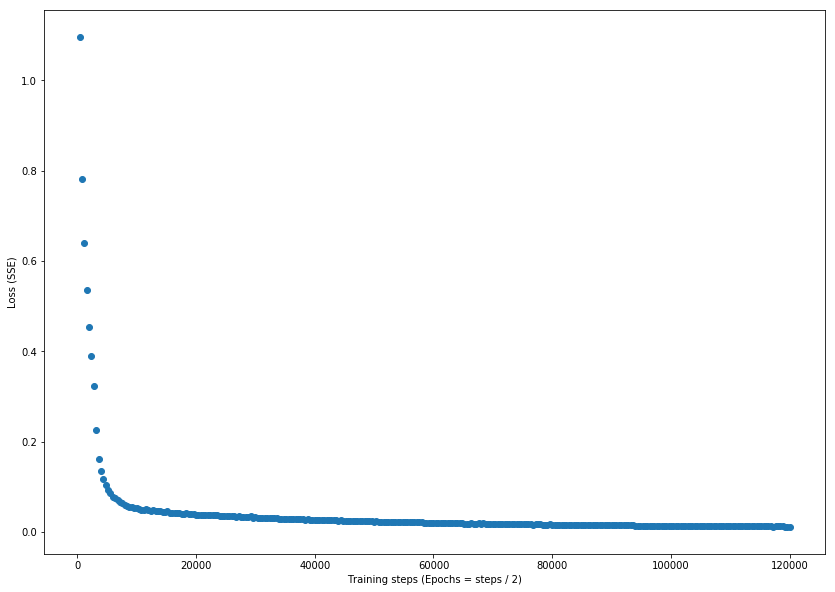

In [30]:
# вручную установливаю параметры фигуры и соответствующий размер
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.show()

In [31]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,
                                              num_epochs=1,
                                              shuffle=False))
predictions = np.array([p['predictions'][0] for p in pred])

print("The Explained Variance: %.2f" % explained_variance_score(
                                            y_test, predictions))  
print("The Mean Absolute Error: %.4f гКалл" % mean_absolute_error(
                                            y_test, predictions))  
print("The Median Absolute Error: %.4f гКалл" % median_absolute_error(
                                            y_test, predictions))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The Explained Variance: 0.95
The Mean Absolute Error: 0.0055 гКалл
The Median Absolute Error: 0.0043 гКалл


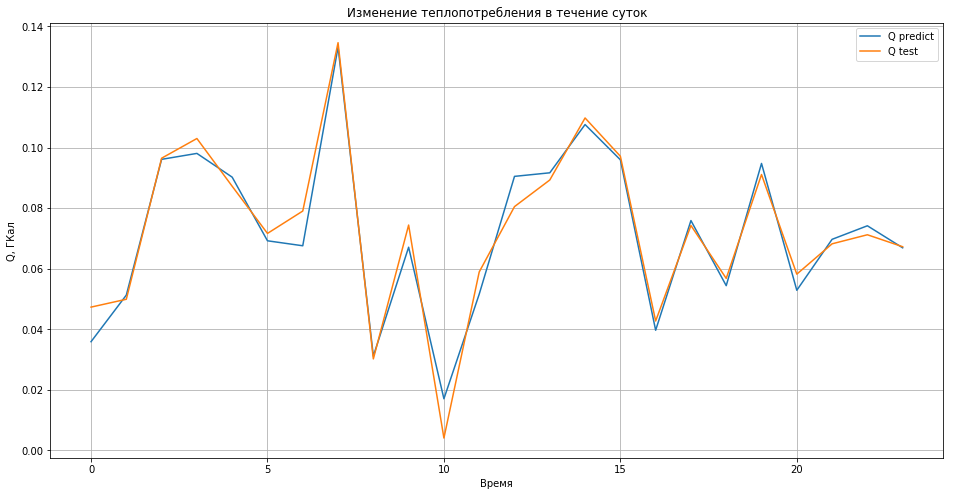

In [32]:
y1 = predictions[0:24]
y2 = y_test[0:24]

x = list(range(0,24))


fig, ax = plt.subplots()


ax.plot(x, y1, label = 'Q predict')
ax.plot(x, y2, label = 'Q test')

ax.legend()
ax.grid()



ax.set_xlabel('Время')
ax.set_ylabel('Q, ГКал')
ax.set_title('Изменение теплопотребления в течение суток')

fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [33]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df

,Actual,Predicted
3167,0.047274,0.035845
2890,0.049868,0.051244
1391,0.096468,0.096097
159,0.102977,0.098057
1566,0.087198,0.090206
2524,0.071620,0.069185
2600,0.079018,0.067541
1525,0.134638,0.133193
3812,0.030166,0.031092
2541,0.074387,0.067062


In [34]:
##Проверка на реальных данных
dataset1 = pd.read_excel('David28(11.04-18.04).xls')

dataset1.drop([0,1], inplace=True)
dataset1 = dataset1.drop(['ЧН', 'Код ошибки'], axis=1)
dataset1.rename(columns={'Время': 'Time', 'Tвн': 'T_home', 'Tнв':'T_Outside'}, inplace=True)
dataset1 = dataset1.query("~(Q <= 0)")
dataset1 = dataset1.fillna(method='ffill')
dataset1.head()

dataset1.describe().T

,count,mean,std,min,25%,50%,75%,max
T_home,192.0,22.840248,0.504936,20.908355,22.664204,23.010102,23.174958,23.498816
Q,192.0,0.049718,0.015673,0.022594,0.037515,0.048180,0.060821,0.095796
M1,192.0,1.598428,0.467689,0.615534,1.218199,1.470506,1.928014,3.622307
M2,192.0,1.287192,0.398758,0.390675,1.008003,1.172411,1.455586,3.035146
dM,192.0,0.311236,0.234087,-0.005565,0.143095,0.280864,0.434119,1.169030
T1,192.0,59.441109,2.599411,44.448093,58.234977,60.110432,61.306014,62.585629
T2,192.0,33.759632,1.956906,30.105814,32.110057,33.503500,35.095414,39.008118
dT,192.0,25.681477,2.335820,11.276474,24.454939,26.081185,27.261018,28.916326
T_Outside,192.0,5.201182,1.961686,1.837203,4.000132,5.138387,6.350162,10.014928
deltaM,192.0,21.761025,15.586356,-0.421862,11.567957,20.829892,29.605457,83.069066


In [36]:
X_dtest = dataset1[['T_home','T_Outside','M1', 'M2', 'P2', 'T1']]
y_dtest = dataset1['Q']
Y_vnesh = dataset1[['T_Outside']]

In [37]:
## загрузка обученной модели 
pred1 = regressor.predict(input_fn=wx_input_fn(X_dtest,
                                              num_epochs=1,
                                              shuffle=False))


predictions1 = np.array([p['predictions'][0] for p in pred1])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\MPC\AppData\Local\Temp\tmp6of3cm09\model.ckpt-120000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [38]:
print ("R Squared using built-in function: ", r2_score( y_dtest, predictions1))

R Squared using built-in function:  0.8163991745181108


In [39]:
print("The Explained Variance: %.2f" % explained_variance_score(
                                            y_dtest, predictions1))  
print("The Mean Absolute Error: %.4f degrees Celcius" % mean_absolute_error(
                                            y_dtest, predictions1))  
print("The Median Absolute Error: %.4f degrees Celcius" % median_absolute_error(
                                            y_dtest, predictions1))

print('Mean Absolute Error: %.6f' % metrics.mean_absolute_error(
                                            y_dtest, predictions1))
print('Mean Squared Error: %.6f' % metrics.mean_squared_error(
                                            y_dtest, predictions1))
print('Root Mean Squared Error: %.6f' % np.sqrt(metrics.mean_squared_error(
                                            y_dtest, predictions1)))

The Explained Variance: 0.82
The Mean Absolute Error: 0.0052 degrees Celcius
The Median Absolute Error: 0.0045 degrees Celcius
Mean Absolute Error: 0.005194
Mean Squared Error: 0.000045
Root Mean Squared Error: 0.006698


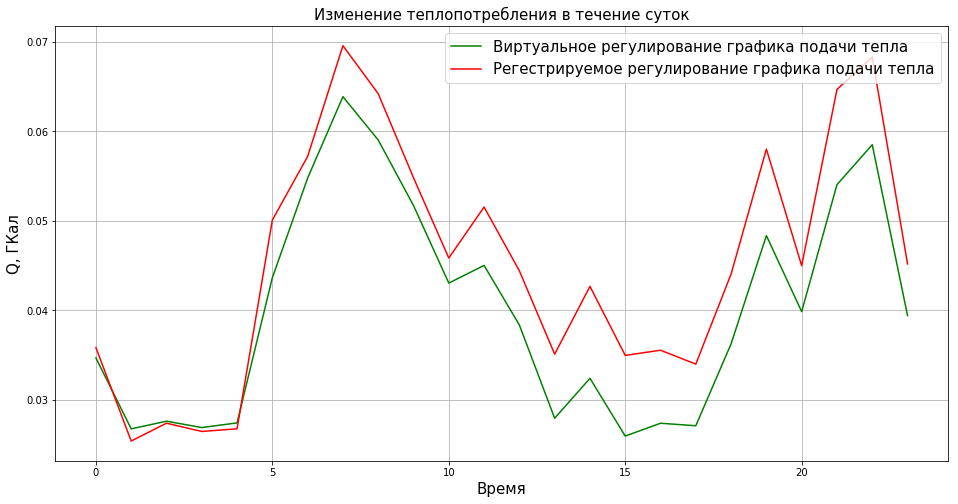

In [40]:
y1 = predictions1[0:24]
x = list(range(0,24))
y2 = y_dtest[0:24]

fig, ax = plt.subplots()


ax.plot(x, y1, label = 'Виртуальное регулирование графика подачи тепла', color ='g')
ax.plot(x, y2, label = 'Регестрируемое регулирование графика подачи тепла', color ='r')

ax.legend(loc = 'upper right', fontsize = 15)
ax.grid()

ax.set_xlabel('Время', fontsize =15)
ax.set_ylabel('Q, ГКал', fontsize =15)
ax.set_title('Изменение теплопотребления в течение суток', fontsize =15)

fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()


In [28]:
df = pd.DataFrame({'Qрег': y_dtest, 'Qм': predictions1})
df1 = df.head(25)
df1

,Qрег,Qм
2,0.035851,0.028621
3,0.025424,0.015489
4,0.027415,0.016469
5,0.026491,0.014900
6,0.026788,0.015965
7,0.050093,0.033669
8,0.057190,0.047991
9,0.069552,0.059087
10,0.064192,0.053887
11,0.054813,0.052093


In [ ]:
##Гистограмма
df1.plot(kind = 'bar', figsize=(10,8))
plt.grid(which='major', linestyle ='-', linewidth='0.5', color = 'black')
plt.grid(which='minor', linestyle =':', linewidth='0.5', color = 'r')
plt.show()